Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


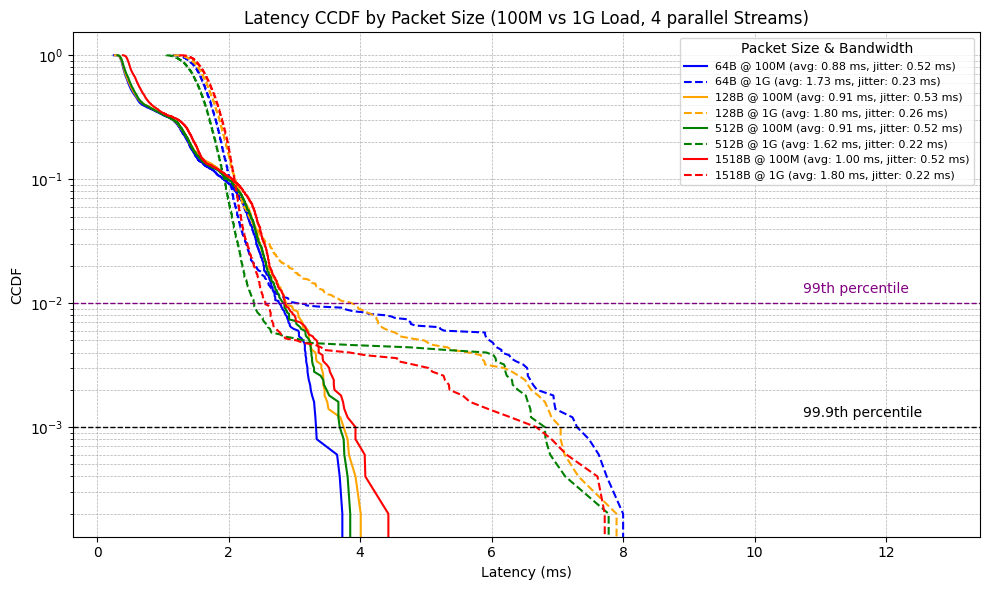

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# =========================
# 🔧 CONFIGURATION SECTION
# =========================
base_paths = {
    "100M": "/content/drive/MyDrive/Test files/CO/latency/4 streams/100M",
    "1G": "/content/drive/MyDrive/Test files/CO/latency/4 streams/1G"
}
packet_sizes = ["64", "128", "512", "1518"]
linestyles = {"100M": "-", "1G": "--"}  # Solid for 100M, dashed for 1G
# =========================

# Extract latency in ms from ping log file
def extract_latencies(filepath):
    latencies = []
    with open(filepath, "r") as f:
        for line in f:
            match = re.search(r'time=(\d+\.\d+)', line)
            if match:
                latency_ms = float(match.group(1))
                latencies.append(latency_ms)
    return np.array(latencies)

# Calculate average jitter
def calculate_jitter(latencies):
    diffs = np.abs(np.diff(latencies))
    return np.mean(diffs)

# Define custom color map: fixed color for each packet size
packet_colors = {
    "64": "blue",
    "128": "orange",
    "512": "green",
    "1518": "red"
}

# Plot CCDF
plt.figure(figsize=(10, 6))

for size in packet_sizes:
    color = packet_colors[size]  # Always same color for a given size
    for bw in ["100M", "1G"]:
        base_path = base_paths[bw]
        file_name = f"ping_{size}_{bw}.log"
        file_path = os.path.join(base_path, file_name)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            continue

        latencies_ms = extract_latencies(file_path)
        sorted_lat = np.sort(latencies_ms)
        ccdf = 1.0 - np.arange(1, len(sorted_lat) + 1) / len(sorted_lat)

        avg_latency = np.mean(latencies_ms)
        avg_jitter = calculate_jitter(latencies_ms)

        label = f"{size}B @ {bw} (avg: {avg_latency:.2f} ms, jitter: {avg_jitter:.2f} ms)"
        plt.plot(sorted_lat, ccdf, label=label, linestyle=linestyles[bw], color=color)

# Percentile guide lines
plt.axhline(1e-2, color="purple", linestyle="--", linewidth=1)
plt.text(plt.xlim()[1]*0.8, 1e-2*1.2, "99th percentile", color="purple")
plt.axhline(1e-3, color="black", linestyle="--", linewidth=1)
plt.text(plt.xlim()[1]*0.8, 1e-3*1.2, "99.9th percentile", color="black")

# Plot appearance
plt.yscale("log")
plt.xlabel("Latency (ms)")
plt.ylabel("CCDF")
plt.title("Latency CCDF by Packet Size (100M vs 1G Load, 4 parallel Streams)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Packet Size & Bandwidth", fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()
